# Change backbone to MobileNet
### First, setup libraries

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
tensorboard = SummaryWriter()

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2


### Prepare data

In [2]:
# Define the data to be used
DATASET = "./datasets/dataset_3+8bags_3var3sc/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [7]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


### GPU?

In [8]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



### Model design and initialization

In [9]:
# Define the loss function
criterion = nn.MSELoss()

# Load the pre-trained MobileNetV3 model
model = models.mobilenet_v3_small(pretrained=True).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1).to(device=device)

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.classifier[3].weight)

# Get all the parameters except for the last layer's weight and bias
base_params = [param for name, param in model.named_parameters()
               if name != "classifier.3.weight" and name != "classifier.3.bias"]

print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

### Training and validation loops

In [10]:
# Define the optimizer, with a greater learning rate for the new last layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.classifier[3].parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 100

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:00<00:00, 63.39batch/s, batch_loss=0.163]


Train loss:  0.3452826154155609
Validation loss:  0.16697187987821444


Epoch 1 [val]: 100%|██████████| 42/42 [00:00<00:00, 64.95batch/s, batch_loss=0.141]


Train loss:  0.10811623915647849
Validation loss:  0.19179782785830043


Epoch 2 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.99batch/s, batch_loss=0.219] 


Train loss:  0.0837370614401805
Validation loss:  0.15391526087408974


Epoch 3 [val]: 100%|██████████| 42/42 [00:00<00:00, 68.08batch/s, batch_loss=0.151] 


Train loss:  0.07640078079241973
Validation loss:  0.14956007383409


Epoch 4 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.05batch/s, batch_loss=0.126] 


Train loss:  0.06730217789419186
Validation loss:  0.11038016971378099


Epoch 5 [val]: 100%|██████████| 42/42 [00:00<00:00, 64.28batch/s, batch_loss=0.1]   


Train loss:  0.06501643294707322
Validation loss:  0.09098664431699685


Epoch 6 [val]: 100%|██████████| 42/42 [00:00<00:00, 67.05batch/s, batch_loss=0.116] 


Train loss:  0.06319869158741756
Validation loss:  0.10950578926574617


Epoch 7 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.63batch/s, batch_loss=0.0867]


Train loss:  0.059901297178405984
Validation loss:  0.09927792545585405


Epoch 8 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.88batch/s, batch_loss=0.0747]


Train loss:  0.056979312929205404
Validation loss:  0.09180796882581144


Epoch 9 [val]: 100%|██████████| 42/42 [00:00<00:00, 67.83batch/s, batch_loss=0.0669]


Train loss:  0.05796153778449083
Validation loss:  0.10346992375950019


Epoch 10 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.16batch/s, batch_loss=0.145] 


Train loss:  0.05587520475188891
Validation loss:  0.09177263932568687


Epoch 11 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.68batch/s, batch_loss=0.0861]


Train loss:  0.054947382546006104
Validation loss:  0.10125829918043953


Epoch 12 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.56batch/s, batch_loss=0.108]  


Train loss:  0.0530802455277015
Validation loss:  0.08801435918680259


Epoch 13 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.82batch/s, batch_loss=0.0814]


Train loss:  0.05471583743317005
Validation loss:  0.07971575226457346


Epoch 14 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.25batch/s, batch_loss=0.0627] 


Train loss:  0.053594062391381994
Validation loss:  0.07981278747320175


Epoch 15 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.82batch/s, batch_loss=0.0977]


Train loss:  0.05114475630987913
Validation loss:  0.07731329552119687


Epoch 16 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.46batch/s, batch_loss=0.126] 


Train loss:  0.05101254899532367
Validation loss:  0.08036852823126883


Epoch 17 [val]: 100%|██████████| 42/42 [00:00<00:00, 67.39batch/s, batch_loss=0.0572]


Train loss:  0.05220558724533289
Validation loss:  0.07700406901893161


Epoch 18 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.85batch/s, batch_loss=0.0374]


Train loss:  0.05045859769750864
Validation loss:  0.0758516565852222


Epoch 19 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.60batch/s, batch_loss=0.0699]


Train loss:  0.05132328289059492
Validation loss:  0.07610466756990977


Epoch 20 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.71batch/s, batch_loss=0.0891]


Train loss:  0.04996244597893495
Validation loss:  0.07681740119698502


Epoch 21 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.41batch/s, batch_loss=0.0875]


Train loss:  0.04919112038153869
Validation loss:  0.08161598027107261


Epoch 22 [val]: 100%|██████████| 42/42 [00:00<00:00, 64.12batch/s, batch_loss=0.0862]


Train loss:  0.04814010012226227
Validation loss:  0.06997562998107501


Epoch 23 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.59batch/s, batch_loss=0.0514]


Train loss:  0.04724120118488104
Validation loss:  0.07184718504902862


Epoch 24 [val]: 100%|██████████| 42/42 [00:00<00:00, 67.31batch/s, batch_loss=0.0712]


Train loss:  0.04664916613449653
Validation loss:  0.07478744492289566


Epoch 25 [val]: 100%|██████████| 42/42 [00:00<00:00, 68.41batch/s, batch_loss=0.0971]


Train loss:  0.048127981638297054
Validation loss:  0.07166963212546848


Epoch 26 [val]: 100%|██████████| 42/42 [00:00<00:00, 68.12batch/s, batch_loss=0.0646]


Train loss:  0.047497416459597076
Validation loss:  0.0663031159589688


Epoch 27 [val]: 100%|██████████| 42/42 [00:00<00:00, 67.25batch/s, batch_loss=0.0631]


Train loss:  0.04753155640493601
Validation loss:  0.07393561427791913


Epoch 28 [val]: 100%|██████████| 42/42 [00:00<00:00, 63.50batch/s, batch_loss=0.065] 


Train loss:  0.04616622818777194
Validation loss:  0.06686891979050069


Epoch 29 [val]: 100%|██████████| 42/42 [00:00<00:00, 64.85batch/s, batch_loss=0.0827]


Train loss:  0.04695799306799204
Validation loss:  0.06633973148252283


Epoch 30 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.34batch/s, batch_loss=0.083] 


Train loss:  0.046297333332208486
Validation loss:  0.07617957672725122


Epoch 31 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.96batch/s, batch_loss=0.076] 


Train loss:  0.04579898407443976
Validation loss:  0.08084605394729547


Epoch 32 [val]: 100%|██████████| 42/42 [00:00<00:00, 66.28batch/s, batch_loss=0.0878]


Train loss:  0.04568530284823515
Validation loss:  0.07574940703454472


Epoch 33 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.81batch/s, batch_loss=0.0765]


Train loss:  0.045093072201005925
Validation loss:  0.08153960977991422


Epoch 34 [val]: 100%|██████████| 42/42 [00:00<00:00, 65.47batch/s, batch_loss=0.0498] 


Train loss:  0.04592375547075883
Validation loss:  0.07230103556953725


Epoch 35 [val]: 100%|██████████| 42/42 [00:00<00:00, 62.14batch/s, batch_loss=0.0307]


Train loss:  0.045306002931335035
Validation loss:  0.06939083541787806


Epoch 36 [val]: 100%|██████████| 42/42 [00:00<00:00, 63.04batch/s, batch_loss=0.104] 


Train loss:  0.045178172469903265
Validation loss:  0.06690380132446687
Early stopping at epoch 36


### Visualization

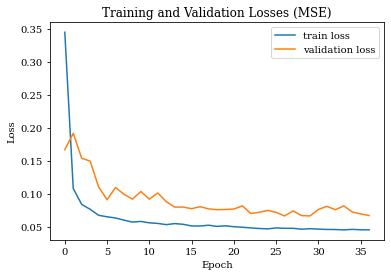

In [11]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses (MSE)")
plt.show()

### Testing

In [12]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.06200482259595691


In [13]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)

Output:
 tensor([[1.8398],
        [1.2309],
        [1.5391],
        [1.8236],
        [1.7630],
        [1.5386],
        [1.6536],
        [1.6837],
        [1.5471],
        [1.6870],
        [1.6941],
        [1.3636],
        [1.6383],
        [1.8881],
        [1.5181],
        [1.9960],
        [1.6259],
        [1.6850],
        [1.8601],
        [1.3048],
        [1.7856],
        [1.5162],
        [1.3262],
        [1.6464],
        [1.6397],
        [1.3841]], device='cuda:0')
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], device='cuda:0',
       dtype=torch.float64)


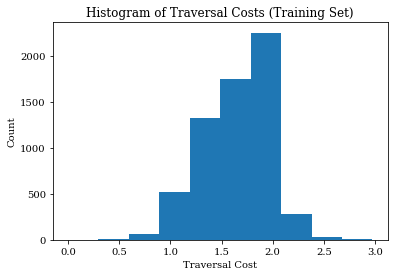

In [14]:
traversal_costs_train = []

for _, score, _ in train_set:
    traversal_costs_train.append(score)
    
plt.hist(traversal_costs_train, bins=10)
plt.xlabel("Traversal Cost")
plt.ylabel("Count")
plt.title("Histogram of Traversal Costs (Training Set)")
plt.show()

### Save model parameters

In [15]:
# Save the model parameters
torch.save(model.state_dict(), "mobilenet.params")